# Data Exploration and Data Preprocessing

## Import

In [1]:
"""dataframe module"""
import pandas as pd
import numpy as np

"""ipynb module"""
from IPython.display import display, HTML

import os
import matplotlib.pyplot as plt
import seaborn as sns

## Constants
Khai báo trước các hằng số để thuận tiện trong việc xử lý dữ liệu bao gồm:
- Cấu trúc các thư mục trong repo 
- Tên file của các địa điểm khác nhau 
- Tên file tiếng Việt của các địa điểm
- Các cột thuộc tính được giữ lại của dữ liệu 
- Các thuộc tính không cho vào quá trình thống kê 
- Tên các cột giá trị thống kê 


In [2]:
RAW_DATA_PATH = '../raw_data/'

CLEANED_DATA_PATH = '../cleaned_data/'

PROCESSED_DATA_PATH = '../processed_data/'

LOCATION_FILE_NAME = ['SonLa','LangSon', 'HaNoi',
                    'NgheAn', 'DaNang', 'LamDong',
                    'HoChiMinh','BenTre']

LOCATION_VALUES = ['Sơn La','Lạng Sơn', 'Hà Nội',
                    'Nghệ An', 'Đà Nẵng', 'Lâm Đồng',
                    'Hồ Chí Minh','Bến Tre']

SAVE_COLS = [ 'Address', 'Datetime', 'DatetimeEpoch',
            'Tempmax', 'Tempmin', 'Temp', 'Dew', 
            'Humidity', 'Precip', 'Precipprob', 'Precipcover',
            'Preciptype', 'Windgust', 'Windspeed', 'Winddir', 
            'Pressure', 'Cloudcover', 'Visibility', 'Solarradiation', 
            'Solarenergy', 'Uvindex', 'Moonphase' ]

NON_STATISTICS_STATS = ['DatetimeEpoch']

STATISTICS_NAMES = ['Count', 'Mean', 'Standard Deviation',
                    'Min', 'Lower Quartile', 'Median',
                    'Upper Quartile', 'Max', 'Missing Ratio',
                    'Range', 'Variance']

ORDERED_STATISTICS = ['Count','Missing Ratio', 'Min', 'Max', 'Mean',
                    'Median', 'Lower Quartile', 'Upper Quartile',
                    'Range',  'Standard Deviation', 'Variance']

## Tiền xử lý dữ liệu raw đã được crawl từ API
Bước này tồn tại do dữ liệu lấy từ API ban đầu không được thống nhất, có cột có, có cột không, thứ tự các cột không được thống nhất, nên cần phải tổ chức lại dữ liệu
- Đây là bước đầu tiên trong phần xử lý 
- Sẽ lấy các file dữ liệu thô được crawl
- Sau đó thêm cột địa điểm (bằng tiếng Việt)
- Bỏ các cột thuộc tính không cần thiết cho việc nghiên cứu 
- Chuẩn hóa tên các cột thuộc tính 
- Xuất các dữ liệu được làm sạch ra file csv (lưu vào folder cleaned_data)

In [3]:
def read_raw_datas() -> list:
    """Takes a location file name and return 
    the pandas dataframe from that csv """
    result_list = []

    for file_name in LOCATION_FILE_NAME:
        df = pd.read_csv(RAW_DATA_PATH + f'{file_name}.csv')
        result_list.append(df)

    return result_list

In [4]:
def read_cleaned_datas() -> list:
    """Takes a location file name and return 
    the pandas dataframe from that csv """
    result_list = []

    for file_name in LOCATION_FILE_NAME:
        df = pd.read_csv(CLEANED_DATA_PATH + f'{file_name}.csv')
        result_list.append(df)

    return result_list

In [5]:
def add_address_column(df, location_name) -> pd.DataFrame:
    """Drop old address columns and add standardized one"""
    if 'Address' in df.columns:
        df.drop('Address', axis=1)
    if 'address' in df.columns:
        df.drop('address', axis=1)

    address_list = [location_name for _ in range(len(df.index))]
    df = df.assign(Address = pd.Series(address_list))
    return df

In [6]:
def drop_unnecessary_columns(df) -> pd.DataFrame:
    """Drop unnecessary features to clean up datas,
    also rearrange columns with a fixed order"""
    df = df[SAVE_COLS]
    return df

In [7]:
def upper_case_name(df) -> pd.DataFrame:
    """Make all columns name uppercase"""
    col_names = df.columns
    upper_col_name = [col_name[0].upper() + col_name[1:]
                      for col_name in col_names]

    df.rename({col_names[i] : upper_col_name[i]
               for i in range(len(col_names))},
              axis=1, inplace=True)

    return df

In [8]:
def export_cleaned_df(df, location_name):
    """export cleaned up dataframe to csv files"""
    df.to_csv(CLEANED_DATA_PATH + f'{location_name}.csv', index=False)

In [9]:
"""Clean function"""
dataframe_list = read_raw_datas()
for i, df in enumerate(dataframe_list):
    df = add_address_column(df, LOCATION_VALUES[i])
    df = upper_case_name(df)
    df = drop_unnecessary_columns(df)
    export_cleaned_df(df, LOCATION_FILE_NAME[i])

## Bắt đầu thực hiện tiền xử lý và khám phá dữ liệu

### Ý nghĩa các cột:
Dựa vào thông tin của trang [Visual Crossing Weather](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/) , tài liệu muốn mang đến một số thông tin, ý nghĩa của các đặc trưng thời tiết (ý nghĩa của từng cột)
### Các đặc trưng chính:
Các cột này biểu diễn các thông tin về thời tiết thường thấy nhất

| **Element**     | **Description**                               | **US**   | **Metric** | **UK**  |
|-----------------|-----------------------------------------------|----------|------------|---------|
| tempmax         | Nhiệt độ tối đa                               | F        | C          | C       |
| tempmin         | Nhiệt độ tối thiểu                            | F        | C          | C       |
| temp            | Nhiệt độ (hoặc nhiệt độ trung bình)           | F        | C          | C       |
| dew             | Điểm sương                                    | F        | C          | C       |
| feelslike       | Cảm giác như                                  | F        | C          | C       |
| precip          | Lượng mưa                                     | inches   | mm         | mm      |
| precipprob      | Xác suất mưa                                  | %        | %          | %       |
| precipcover     | Tỷ lệ mưa                                     | %        | %          | %       |
| preciptype      | Loại mưa                                      | –        | –          | –       |
| snow            | Tuyết                                         | inches   | cm         | cm      |
| snowdepth       | Độ dày tuyết                                  | inches   | cm         | cm      |
| windspeed       | Tốc độ gió                                    | mph      | kph        | mph     |
| windgust        | Cơn gió giật                                  | mph      | kph        | mph     |
| winddir         | Hướng gió                                     | degrees  | degrees    | degrees |
| visibility      | Tầm nhìn                                      | miles    | km         | miles   |
| cloudcover      | Độ che phủ của mây                            | %        | %          | %       |
| humidity        | Độ ẩm tương đối                               | %        | %          | %       |
| pressure        | Áp suất mực nước biển                         | mb       | mb         | mb      |
| solarradiation  | Bức xạ mặt trời                               | W/m²     | W/m²       | W/m²    |
| solarenergy     | Năng lượng mặt trời                           | MJ/m²    | MJ/m²      | MJ/m²   |
| uvindex         | Chỉ số UV                                     | –        | –          | –       |
| severerisk      | Rủi ro nghiêm trọng                           | –        | –          | –       |
| sunrise         | Thời gian mặt trời mọc                        | –        | –          | –       |
| sunset          | Thời gian mặt trời lặn                        | –        | –          | –       |
| moonphase       | Pha mặt trăng                                 | –        | –          | –       |
| icon            | Biểu tượng thời tiết                          | –        | –          | –       |
| conditions      | Mô tả ngắn về thời tiết                       | –        | –          | –       |
| description     | Mô tả chi tiết thời tiết trong ngày           | –        | –          | –       |
| stations        | Danh sách các trạm khí tượng cung cấp dữ liệu | –        | –          | –       |

### Temperature (temp, tempmax, tempmin)
Có ba cột chính chỉ nhiệt độ - Nhiệt độ tối thiểu, Nhiệt độ tối đa và Nhiệt độ trung bình. Những cột này trả về dữ liệu bằng độ Fahrenheit, độ Celsius hoặc độ Kelvin tùy thuộc vào nhóm đơn vị (unit group).

### Wind (wspd, wdir, wgust)
Dữ liệu gió bao gồm tốc độ gió, cơn gió giật và hướng gió.

**Tốc độ gió và hướng gió (wspd, wdir)**
Tốc độ và hướng gió chỉ ra tốc độ và hướng của gió tại địa điểm và thời gian yêu cầu. Tốc độ gió đo được tính trung bình hai phút trước khi được ghi nhận.

Tốc độ gió thường được đo 10 mét trên mặt đất với không vật cản. Đơn vị của hướng gió là độ, với 0&deg; (bắt đầu hướng Bắc), tới 90&deg; (bắt đầu hướng Đông), tới 180&deg; (bắt đầu hướng Nam), tới 270&deg; (bắt đầu hướng Tây).

**Cơn gió giật (wgust)**
Cơn gió giật là tốc độ gió tối đa đo được trong khoảng thời gian ngắn (thường dưới 20 giây). Lưu ý rằng cơn gió giật yêu cầu tốc độ gió ngắn hạn đo được phải cao hơn đáng kể so với tốc độ gió trung bình. Thông thường, tốc độ gió phải cao hơn 10 hải lý (11 mph hoặc 18 kph). Khi cơn gió giật không đạt các tiêu chí này, một giá trị rỗng/null sẽ được trả về.

### Precipitation (precip, precipchance và precipcover)
Lượng mưa là tổng lượng nước mưa, tuyết hoặc các loại mưa khác rơi trong khoảng thời gian xác định.

**Lượng mưa (precip)**
Lượng mưa đã hoặc dự đoán sẽ rơi trong khoảng thời gian nhất định. Các giá trị được biểu thị bằng inch hoặc mm.

**Khả năng có mưa (precipprob)**
Khả năng có mưa trong khoảng thời gian được chỉ định, được biểu thị bằng phần trăm từ 0-100%. Điều này chỉ áp dụng cho các truy vấn dự báo.

**Độ phủ lượng mưa(precipcover)**
Đây là tỷ lệ thời gian có mưa đo được trong khoảng thời gian, được biểu thị bằng phần trăm. Ví dụ, trong một ngày 24 giờ có sáu giờ có mưa đo được, độ phủ lượng mưa là 25% (6/24*100). Thông tin này chỉ có sẵn cho dữ liệu quan sát thời tiết lịch sử và tóm tắt lịch sử. Lưu ý rằng lượng mưa không đáng kể được coi là giá trị bằng không trong cột lượng mưa, nhưng báo cáo về lượng mưa không đáng kể sẽ được tính là có mưa trong cột độ phủ lượng mưa. Vì vậy, có thể quan sát lượng mưa báo cáo bằng không nhưng độ phủ lượng mưa không bằng không.

**Loại lượng mưa (preciptype)**
(Chỉ dự báo) Cung cấp loại lượng mưa dự kiến. Các giá trị có thể bao gồm mưa, tuyết, mưa đông giá và băng.

### Độ che phủ (cloudcover)
**Độ che phủ của mây** là phần trăm bầu trời bị che phủ bởi mây. Được tính cho mọi độ cao. Nếu lấy giá trị hàng ngày thì sẽ bao gồm thêm giá trị trung bình độ che phủ được đo theo tiếng

### Tuyết và độ dày tuyết (snow, snowdepth)
**Tuyết** là lượng tuyết mới rơi trong khoảng thời gian.
  
**Độ dày tuyết** là độ dày tuyết trung bình hiện có trên mặt đất.

### Độ ẩm tương đối, chỉ số nhiệt, cảm giác lạnh, cảm giác nhiệt(humidity, heatindex, windchill, feelslike)
**Độ ẩm tương đối (humidity)**
Độ ẩm tương đối là lượng hơi nước có trong không khí so với lượng tối đa có thể có ở một nhiệt độ nhất định, được biểu thị bằng phần trăm trung bình. Mức độ thoải mái của con người thường nằm trong khoảng từ 30-70%. Giá trị cao hơn 70% được coi là ẩm, trong khi giá trị thấp hơn 30% được coi là khô.

**Chỉ số nhiệt(Heat Index)** là mức độ nóng mà người ta cảm thấy khi kết hợp giữa nhiệt độ thực tế và độ ẩm tương đối. Độ ẩm cao khiến cảm giác nóng hơn nhiệt độ thực tế. Giá trị của chỉ số nhiệt được biểu thị cùng đơn vị với nhiệt độ. Chỉ số nhiệt chỉ được tính khi nhiệt độ lớn hơn 80°F (khoảng 26,7°C) và độ ẩm tương đối trên 40%. Ngoài các phạm vi này, giá trị trả về sẽ là rỗng.

**Cảm giác lạnh(Wind Chill)** là mức độ lạnh mà người ta cảm thấy khi kết hợp nhiệt độ thực tế với tốc độ gió. Gió làm nhiệt độ cảm thấy lạnh hơn so với khi không có gió. Giá trị được biểu thị cùng đơn vị với nhiệt độ. Cảm giác lạnh chỉ được tính khi nhiệt độ dưới 50°F (khoảng 10°C) và tốc độ gió trên 3 mph (5 kph). Ngoài các phạm vi này, giá trị trả về sẽ là rỗng.

**Cảm giác nhiệt (feelslike)**
Nhiệt độ, chỉ số nhiệt và cảm giác lạnh được kết hợp thành một yếu tố duy nhất gọi là “cảm giác nhiệt” để dễ hiểu và dễ sử dụng. Giá trị tối đa hàng ngày (feelslikemax) và giá trị tối thiểu hàng ngày (feelslikemin) được bao gồm trong các giá trị hàng ngày.

### Nhiệt độ điểm sương (dew)
Biểu thị nhiệt độ mà không khí cần phải được làm lạnh xuống để đạt độ bảo hòa, làm cho hơi nước trong không khí ngưng tụ thành nước

### Tầm nhìn (Visibility)
**Tầm nhìn** là khoảng cách có thể quan sát được vào ban ngày. Điều này bao gồm các hiện tượng thời tiết như sương mù, khói,...

### Áp suất khí quyển (sealevelpressure or pressure)
**Áp suất khí quyển** ở một vị trí mà không có sự giảm áp do độ cao.

### Bức xạ mặt trời và năng lượng mặt trời(Solar radiation and solar energy)
**Bức xạ mặt trời** đo công suất bức xạ tại ngay thời điểm quan sát.  

**Năng lượng mặt trời** là tổng năng lượng từ mặt trời tích lũy trong một giờ hoặc ngày.

### Tia UV (UV Index)
Giá trị từ 0 đến 10 chỉ mức độ tiếp xúc tia UV.

### Thời tiết khắc nghiệt (CAPE, CIN, severe risk)
- **Severe risk** là giá trị nằm trong khoảng từ 0 đến 100, thể hiện mức độ rủi ro của các cơn bão đối lưu (ví dụ: sấm sét, mưa đá và lốc xoáy). Severe risk là một thang đo kết hợp từ nhiều yếu tố như năng lượng tiềm năng đối lưu (CAPE), sự ức chế đối lưu (CIN), lượng mưa và gió dự đoán. Thông thường, giá trị severe risk dưới 30 cho thấy rủi ro thấp, từ 30 đến 70 là rủi ro trung bình và trên 70 là rủi ro cao.

- **CAPE** – **Năng lượng tiềm năng đối lưu**: Là giá trị biểu thị năng lượng có thể tạo ra các cơn bão sấm sét. Giá trị CAPE cao hơn cho thấy bầu khí quyển không ổn định, có khả năng tạo ra các cơn bão mạnh hơn. Giá trị dưới 1000 J/kg cho thấy bầu khí quyển có độ bất ổn định thấp, từ 1000-2500 J/kg là mức trung bình, 2500-4000 J/kg là mức cao và trên 4000 J/kg cho thấy bầu khí quyển cực kỳ bất ổn định.

- **CIN** – **Sự ức chế đối lưu**: Là giá trị biểu thị mức độ ngăn chặn bầu khí quyển khỏi sự bất ổn, do đó hạn chế sự hình thành của các cơn bão.

### Trạng thái thời tiết (Weather Type)
Các điều kiện thời tiết đáng chú ý được báo cáo tại một địa điểm cụ thể, ví dụ như bão, mưa,..ect

### Thông tin về thiên văn học(Astronomical information)
Thời gian mặt trời mọc và lặn, pha mặt trăng, thời gian dựa vào thời gian địa phương

### Chu kỳ trăng(Moonphase)
Giá trị thập phân biểu thị pha mặt trăng hiện tại, nằm trong khoảng từ 0 đến 1, trong đó:
- **0** – Trăng non
- **0-0.25** – Trăng lưỡi liềm đầu tháng
- **0.25** – Trăng thượng huyền
- **0.25-0.5** – Trăng khuyết đầu tháng
- **0.5** – Trăng tròn
- **0.5-0.75** – Trăng khuyết cuối tháng
- **0.75** – Trăng hạ huyền
- **0.75-1** – Trăng lưỡi liềm cuối tháng

### Icons
Trường **icon** chứa một giá trị văn bản mà người dùng có thể sử dụng để hiển thị biểu tượng khi trình bày dữ liệu thời tiết.

### Mô tả và hỗ trợ ngôn ngữ
Các mô tả văn bản được bao gồm có thể trả về bằng các ngôn ngữ khác nhau bằng cách sử dụng tham số API **'lang'**.

### Các trạm đo đạc(Contributing Stations)
Đưa ra danh sách các trạm đã được sử dụng để đo đạc, bao gồm danh sách tên và ID, khoảng cách từ địa điểm được yêu cầu tới vị trí các trạm.

## Cấu trúc dữ liệu(General weather data structure)
Giới thiệu về cấu trúc bộ dữ liệu của các danh mục dữ liệu chính - dự báo thời tiết, quan sát thời tiết lịch sử và tổng quan thời tiết lịch sử.

**Cấu trúc Bộ Dữ Liệu (Data Set Structure)**  
Tất cả các bộ dữ liệu có cấu trúc bảng đơn giản và có sẵn ở nhiều định dạng bao gồm văn bản phân tách như CSV, JSON và ODATA. Dữ liệu bao gồm một hàng tiêu đề, cung cấp thông tin về nội dung của từng cột. Các tiêu đề cột này có thể ở dạng dễ đọc cho con người và có thể dịch được hoặc ở dạng ngắn gọn không dịch được. Dạng ngắn gọn thường được sử dụng trong **Weather API** để dễ dàng truy xuất dữ liệu. Khi sử dụng **Weather API**, tham số **shortColumnNames** sẽ xác định có sử dụng tên cột ngắn hay không.

**Tập Hợp Dữ Liệu Theo Giờ và Hàng Ngày (Hourly and Daily Dataset Aggregation)**  
Tất cả dữ liệu trong hệ thống đều được tính toán ở mức dữ liệu hàng giờ để đảm bảo độ chính xác và nhất quán. Khi có yêu cầu cho các khoảng thời gian dài hơn, chẳng hạn như dự báo thời tiết hàng ngày hoặc tổng kết lịch sử hàng tháng, dữ liệu hàng giờ sẽ được tổng hợp bằng cách sử dụng các phương pháp trung bình (mean), tổng (sum), giá trị nhỏ nhất (min), hoặc giá trị lớn nhất (max).

**Nhóm Đơn Vị (Unit group)**  
Đơn vị đo lường của dữ liệu được xác định bởi nhóm đơn vị toàn bộ, chẳng hạn như hệ mét, hệ US, v.v. Nhóm đơn vị này xác định đơn vị đo lường cho từng loại cột – tất cả các cột của cùng một loại biến sẽ có cùng đơn vị đo lường. Ví dụ, nếu nhóm đơn vị được đặt là hệ mét, thì tất cả các giá trị liên quan đến nhiệt độ sẽ được đo bằng Celsius.

**Các Cột Chung (Common columns)**  
Các bộ dữ liệu thường bao gồm thông tin về vị trí (location), khoảng thời gian hoặc thời gian dữ liệu(period, data time). Nếu dữ liệu yêu cầu bao gồm địa chỉ (address), thông tin địa chỉ cũng sẽ có trong kết quả trả về. Ngoài ra, vĩ độ (latitude) và kinh độ (longtitude) của các vị trí yêu cầu sẽ được trả về dưới dạng độ thập phân. Giá trị kinh độ được tính từ kinh tuyến gốc, với giá trị âm là phía tây và dương là phía đông so với kinh tuyến gốc.

**Giá Trị Trống (Empty values)**  
Các giá trị trống (hoặc giá trị null) được sử dụng trong bộ dữ liệu để chỉ sự thiếu dữ liệu, chẳng hạn như thông tin thời tiết bị thiếu hoặc dữ liệu chưa xác định. Chúng không được sử dụng để chỉ giá trị bằng không. Ví dụ, một giá trị lượng mưa không xác định sẽ được đánh dấu là trống hoặc null. Một lượng mưa bằng không sẽ được hiển thị với giá trị là số 0.  

### Duplication
- Kiểm tra xem có xuất hiện dòng dữ liệu nào bị trùng không
- Nếu có thì ta sẽ tiến hành loại bỏ các dòng dữ liệu bị trùng 

In [10]:
def is_duplicated(df) -> bool:
    """Check if a dataframe have duplicated row"""
    dup_count = df.duplicated().sum()
    return dup_count 

In [11]:
def check_duplicated():
    """check if any file have duplicated datas"""
    dataframe_list = read_cleaned_datas()
    is_dup = False
    for country_df in dataframe_list: 
        num_duplicated_rows = 0
        num_duplicated_rows += is_duplicated(country_df)

        if num_duplicated_rows:
            print(f"Your raw data {country_df['Address'][0]}.csv have {num_duplicated_rows}",
                "duplicated data. Please de-deduplicate your raw data.!")
            is_dup = True
    
    if not is_dup:
        print("Your data doesn't have duplicated data")


In [12]:
check_duplicated()

Your data doesn't have duplicated data


### Dimensions
- Số chiều của dữ liệu thu thập là bao nhiêu 
- Mỗi một địa điểm có bao nhiêu dòng 
- Các dữ liệu có bao nhiêu thuộc tính 

In [13]:
raw_df = pd.read_csv(CLEANED_DATA_PATH +'DaNang.csv')
shape = raw_df.shape
print('Current shape (1 location): ', shape)

Current shape (1 location):  (1827, 22)


### Kiểu dữ liệu 
- Mỗi một thuộc tính có kiểu dữ liệu gì ?
- Các kiểu dữ liệu này có phù hợp việc xử lý hay không ? 

In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         1827 non-null   object 
 1   Datetime        1827 non-null   object 
 2   DatetimeEpoch   1827 non-null   int64  
 3   Tempmax         1827 non-null   float64
 4   Tempmin         1827 non-null   float64
 5   Temp            1827 non-null   float64
 6   Dew             1827 non-null   float64
 7   Humidity        1827 non-null   float64
 8   Precip          1827 non-null   float64
 9   Precipprob      1827 non-null   float64
 10  Precipcover     1827 non-null   float64
 11  Preciptype      1070 non-null   object 
 12  Windgust        1827 non-null   float64
 13  Windspeed       1827 non-null   float64
 14  Winddir         1827 non-null   float64
 15  Pressure        1827 non-null   float64
 16  Cloudcover      1827 non-null   float64
 17  Visibility      1827 non-null   f


| Cột                | Kiểu Dữ Liệu Hiện Tại | Đánh Giá      |
|--------------------|-----------------------|---------------|
| **Address**        | `object`  | Phù hợp. Cột này lưu tên địa chỉ (tỉnh, thành phố) và nên là kiểu `object`.                               |
| **Datetime**       | `object`              | Không hoàn toàn phù hợp. Để tiện thao tác, nên chuyển sang kiểu `datetime64[ns]`.                         |
| **DatetimeEpoch**  | `int64`               | Phù hợp. Cột này lưu giá trị thời gian tính bằng giây, nên kiểu số nguyên là hợp lý.                     |
| **Tempmax**        | `float64`             | Phù hợp. Nhiệt độ tối đa có thể có giá trị thập phân, nên kiểu `float64` là phù hợp.                      |
| **Tempmin**        | `float64`             | Phù hợp. Nhiệt độ tối thiểu nên là kiểu `float64` để lưu các giá trị thập phân.                           |
| **Temp**           | `float64`             | Phù hợp. Nhiệt độ trung bình cũng nên là kiểu `float64`.                                                  |
| **Dew**            | `float64`             | Phù hợp. Điểm sương cũng là nhiệt độ và nên ở kiểu `float64`.                                             |
| **Humidity**       | `float64`             | Phù hợp. Độ ẩm là phần trăm và có thể có giá trị thập phân, nên `float64` là phù hợp.                     |
| **Precip**         | `float64`             | Phù hợp. Lượng mưa có thể có giá trị thập phân (mm), nên `float64` là hợp lý.                             |
| **Precipprob**     | `float64`             | Phù hợp. Xác suất mưa là phần trăm, nên có thể lưu dạng `float64`.                                        |
| **Precipcover**    | `float64`             | Phù hợp. Độ che phủ mưa cũng là phần trăm, `float64` là phù hợp.                                          |
| **Preciptype**     | `object`              | Phù hợp. Kiểu mưa (ví dụ: "rain", "snow") là chuỗi, nên `object` là phù hợp.                              |
| **Windgust**       | `float64`             | Phù hợp. Tốc độ gió lớn nhất thường có giá trị thập phân, nên kiểu `float64` là hợp lý.                   |
| **Windspeed**      | `float64`             | Phù hợp. Tốc độ gió trung bình cũng nên là kiểu `float64`.                                                |
| **Winddir**        | `float64`             | Phù hợp. Hướng gió là giá trị góc (độ), nên `float64` là phù hợp.                                         |
| **Pressure**       | `float64`             | Phù hợp. Áp suất có thể có giá trị thập phân, nên `float64` là hợp lý.                                    |
| **Cloudcover**     | `float64`             | Phù hợp. Độ che phủ mây là phần trăm và có thể có giá trị thập phân, nên `float64` là phù hợp.            |
| **Visibility**     | `float64`             | Phù hợp. Tầm nhìn có thể có giá trị thập phân (km), nên `float64` là hợp lý.                              |
| **Solarradiation** | `float64`             | Phù hợp. Bức xạ mặt trời có giá trị thập phân, nên `float64` là phù hợp.                                  |
| **Solarenergy**    | `float64`             | Phù hợp. Năng lượng mặt trời cũng có giá trị thập phân, nên `float64` là hợp lý.                          |
| **Uvindex**        | `float64`             | Phù hợp. Chỉ số UV là số nguyên dương, nhưng `float64` vẫn phù hợp để phòng ngừa dữ liệu thập phân.       |
| **Moonphase**      | `float64`             | Phù hợp. Pha mặt trăng là một giá trị thập phân từ 0 đến 1, nên `float64` là hợp lý.                      |

### Kết luận:
- **Datetime:** Nên chuyển sang kiểu `datetime64[ns]` để dễ dàng thao tác với dữ liệu ngày.
- Các cột còn lại đều phù hợp với kiểu dữ liệu hiện tại và không cần thay đổi thêm.

### Kiểm tra xem có thuộc tính nào bị thiếu dữ liệu hay không 

In [15]:
def missing_ratio(arr):
    ratio = arr.isna().mean()
    return ratio

In [16]:
def check_missing():
    for location in LOCATION_FILE_NAME:
        df = pd.read_csv(CLEANED_DATA_PATH + f'{location}.csv', index_col=0)
        tmp = df.agg([missing_ratio])
        filtered = [h for h in tmp.columns if tmp[h].iloc[0] > 0]
        print(location)
        print(tmp[filtered])

In [17]:
check_missing()

SonLa
               Preciptype  Visibility
missing_ratio    0.358511    0.001642
LangSon
               Preciptype  Visibility
missing_ratio    0.249042    0.000547
HaNoi
               Preciptype
missing_ratio    0.282978
NgheAn
               Preciptype  Visibility
missing_ratio    0.343186    0.001642
DaNang
               Preciptype
missing_ratio     0.41434
LamDong
               Preciptype  Visibility
missing_ratio     0.15873    0.604817
HoChiMinh
               Preciptype
missing_ratio    0.254516
BenTre
               Preciptype
missing_ratio    0.238643


### Nếu có dữ liệu bị thiếu thì thay các dòng bị thiếu bằng giá trị trung vị
**Lý do:**
- Dữ liệu có phân phối lệch (skewed distribution): Khi dữ liệu có phân phối không đối xứng (như phân phối lệch phải hoặc lệch trái), giá trị trung vị đại diện tốt hơn so với giá trị trung bình vì nó không bị ảnh hưởng bởi các giá trị ngoại lai (outliers).

- Dữ liệu có giá trị ngoại lai (outliers): Nếu dữ liệu có các giá trị cực lớn hoặc cực nhỏ bất thường, giá trị trung vị sẽ phản ánh trung thực hơn "trung tâm" của dữ liệu so với trung bình.

- Dữ liệu thứ tự (ordinal data): Khi xử lý dữ liệu thứ tự, chẳng hạn như xếp hạng hoặc mức độ (ví dụ: "thấp", "trung bình", "cao"), giá trị trung vị là cách thay thế phù hợp vì nó không đòi hỏi tính toán phức tạp như trung bình.

**Áp dụng vào dữ liệu đang có:**
- Sau khi đọc qua về ý nghĩa các cột, ta thấy chỉ cần thêm dữ liệu thiếu cho cột Visibility, còn cột Preciptype không cần thêm dữ liệu thiếu mà hãy dữ nguyên

In [18]:
def fill_median(x):
    return x.fillna(x.median())

In [19]:
# Chứa dataframe đã được xử lý dữ liệu của các tỉnh thành 
processed_df = []

def fill_missing():
    for location in LOCATION_FILE_NAME:
        df = pd.read_csv(CLEANED_DATA_PATH + f'{location}.csv')
        df['Visibility'] = df.groupby('Address')['Visibility'].transform(fill_median)
        tmp = df.agg([missing_ratio])
        filtered = [h for h in tmp.columns if tmp[h].iloc[0] > 0]
        print(location)
        print(tmp[filtered])
        processed_df.append((location, df))

In [20]:
fill_missing() # fill missing values và kiểm tra kết quả

SonLa
               Preciptype
missing_ratio    0.358511
LangSon
               Preciptype
missing_ratio    0.249042
HaNoi
               Preciptype
missing_ratio    0.282978
NgheAn
               Preciptype
missing_ratio    0.343186
DaNang
               Preciptype
missing_ratio     0.41434
LamDong
               Preciptype
missing_ratio     0.15873
HoChiMinh
               Preciptype
missing_ratio    0.254516
BenTre
               Preciptype
missing_ratio    0.238643


### Lưu dữ liệu sau khi đã xử lý

In [21]:
def export_processed_df(df, location_name):
    """export processed dataframe to csv files"""
    df.to_csv(PROCESSED_DATA_PATH + f'{location_name}.csv', index=False)

def save_processed_df(processed_dataframes):
    for location, df in processed_dataframes:
        export_processed_df(df, location)

In [22]:
save_processed_df(processed_df)

### Statistics
- Các giá trị thống kê mô tả của dữ liệu 
- Mỗi một địa điểm có các giá trị thống kê như sau: 
    - Các giá trị min, max, mean, median, lower(upper) quartile
    - Miền giá trị của các thuộc tính, độ lệch chuẩn và phương sai

#### Hàm đổi tên các cột thuộc tính thống kê 

In [23]:
def standardize_statistics(df) -> pd.DataFrame:
    """Change column's names to standard name 
    and re-order all the columns"""

    old_name = df.columns.tolist()
    df.rename({old_name[i] : STATISTICS_NAMES[i]
               for i in range(len(df.columns))},
               axis = 1, inplace = True)

    df = df[ORDERED_STATISTICS]
    return df 

#### Hàm tạo bảng thống kê cho từng dataframe

In [24]:
def Statistics (df) -> pd.DataFrame: 

    stats = [x for x in df.columns.to_list() if x not in NON_STATISTICS_STATS]
    result_df = df[stats].describe().round(2)
    # update columns name 
    stats = result_df.columns.to_list()
    # print(stats)

    missing_list = []
    range_list = []
    variance = []

    for col in stats: 
        missing_list.append(missing_ratio(df[col]))
        range_list.append(result_df[col]['max'] - result_df[col]['min'])
        variance.append(df[col].var())

    result_df.loc['Missing ratio'] = missing_list
    result_df.loc['Range'] = range_list
    result_df.loc['Variance'] = variance

    return result_df.T

#### Hiển thị các bảng thống kê cho từng địa điểm thu thập được 

In [25]:
for location in LOCATION_FILE_NAME:
    raw_df = pd.read_csv(CLEANED_DATA_PATH + location + '.csv', index_col=0)
    stat_df = Statistics(raw_df)
    stat_df = standardize_statistics(stat_df)
    print(location)
    display(stat_df)
    print()

SonLa


Count  Missing Ratio    Min      Max     Mean   Median  \
Tempmax         1827.0       0.000000    7.9    39.10    27.77    28.60   
Tempmin         1827.0       0.000000    2.7    26.10    17.80    18.80   
Temp            1827.0       0.000000    6.9    31.20    22.08    22.80   
Dew             1827.0       0.000000    1.2    24.50    17.75    18.80   
Humidity        1827.0       0.000000   31.9    98.30    78.65    80.00   
Precip          1827.0       0.000000    0.0   146.00     3.84     0.30   
Precipprob      1827.0       0.000000    0.0   100.00    63.11   100.00   
Precipcover     1827.0       0.000000    0.0    70.83     7.59     4.17   
Windgust        1827.0       0.000000    4.3    79.20    24.98    24.80   
Windspeed       1827.0       0.000000    4.0    28.80    10.61    10.80   
Winddir         1827.0       0.000000    2.3   359.40   171.92   134.40   
Pressure        1827.0       0.000000  998.6  1029.10  1011.70  1011.10   
Cloudcover      1827.0       0.000000    0.0   100.00    64.21    67.60   
Visibility      1824.0       0.001642    6.8    23.90    18.79    20.00   
Solarradiation  1827.0       0.000000    6.4   330.30   193.87   201.60   
Solarenergy     1827.0       0.000000    0.6    28.60    16.74    17.40   
Uvindex         1827.0       0.000000    0.0    10.00     7.08     8.00   
Moonphase       1827.0       0.000000    0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  25.20           31.10   31.20                4.80   
Tempmin                  14.60           21.40   23.40                4.59   
Temp                     19.20           25.40   24.30                4.39   
Dew                      14.60           21.80   23.30                4.66   
Humidity                 74.70           84.50   66.40                9.43   
Precip                    0.00            2.80  146.00               10.11   
Precipprob                0.00          100.00  100.00               48.26   
Precipcover               0.00            8.33   70.83               10.26   
Windgust                 19.10           30.80   74.90                9.19   
Windspeed                 7.90           11.90   24.80                3.32   
Winddir                 123.60          242.30  357.10               83.30   
Pressure               1006.50         1016.35   30.50                6.00   
Cloudcover               45.85           88.20  100.00               26.64   
Visibility               17.50           20.70   17.10                3.17   
Solarradiation          144.40          248.95  323.90               71.14   
Solarenergy              12.40           21.50   28.00                6.15   
Uvindex                   6.00            9.00   10.00                2.15   
Moonphase                 0.25            0.75    0.98                0.29   

                   Variance  
Tempmax           23.045023  
Tempmin           21.097164  
Temp              19.308399  
Dew               21.731361  
Humidity          89.014600  
Precip           102.173143  
Precipprob      2329.431174  
Precipcover      105.217356  
Windgust          84.436286  
Windspeed         11.025197  
Winddir         6939.714058  
Pressure          35.961087  
Cloudcover       709.938340  
Visibility        10.039619  
Solarradiation  5060.803523  
Solarenergy       37.857014  
Uvindex            4.634276  
Moonphase          0.083536


LangSon


Count  Missing Ratio    Min      Max     Mean   Median  \
Tempmax         1827.0       0.000000    6.6    37.70    26.57    27.50   
Tempmin         1827.0       0.000000    1.7    27.60    18.76    20.00   
Temp            1827.0       0.000000    4.2    31.60    22.15    23.10   
Dew             1827.0       0.000000   -3.9    27.00    18.38    20.10   
Humidity        1827.0       0.000000   35.9    98.60    80.71    82.60   
Precip          1827.0       0.000000    0.0   183.72     4.10     0.40   
Precipprob      1827.0       0.000000    0.0   100.00    73.89   100.00   
Precipcover     1827.0       0.000000    0.0    66.67     9.37     8.33   
Windgust        1827.0       0.000000    8.6    79.20    32.05    31.00   
Windspeed       1827.0       0.000000    4.7    39.60    14.29    13.70   
Winddir         1827.0       0.000000    2.9   356.60   110.45   137.80   
Pressure        1827.0       0.000000  996.4  1030.30  1011.81  1011.50   
Cloudcover      1827.0       0.000000    0.0   100.00    72.42    80.40   
Visibility      1826.0       0.000547    1.6    21.80    14.12    12.50   
Solarradiation  1827.0       0.000000    7.6   335.30   165.28   169.20   
Solarenergy     1827.0       0.000000    0.7    29.00    14.27    14.60   
Uvindex         1827.0       0.000000    0.0    10.00     6.16     7.00   
Moonphase       1827.0       0.000000    0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  22.40           31.70   31.10                6.15   
Tempmin                  14.70           23.50   25.90                5.61   
Temp                     18.35           26.80   27.40                5.50   
Dew                      14.30           23.70   30.90                6.22   
Humidity                 76.20           87.20   62.70               10.02   
Precip                    0.00            2.00  183.72               12.21   
Precipprob                0.00          100.00  100.00               43.93   
Precipcover               0.00           12.50   66.67               10.13   
Windgust                 23.40           39.60   70.60               11.47   
Windspeed                10.40           17.60   34.90                5.30   
Winddir                  26.60          178.50  353.70               78.29   
Pressure               1005.80         1017.40   33.90                7.02   
Cloudcover               57.55           93.25  100.00               25.91   
Visibility               11.30           18.90   20.20                4.33   
Solarradiation           94.50          232.65  327.70               82.62   
Solarenergy               8.15           20.00   28.30                7.14   
Uvindex                   4.00            8.00   10.00                2.59   
Moonphase                 0.25            0.75    0.98                0.29   

                   Variance  
Tempmax           37.846779  
Tempmin           31.486547  
Temp              30.226926  
Dew               38.710396  
Humidity         100.467105  
Precip           149.060608  
Precipprob      1930.246737  
Precipcover      102.551455  
Windgust         131.665026  
Windspeed         28.053243  
Winddir         6129.081693  
Pressure          49.303467  
Cloudcover       671.086813  
Visibility        18.788195  
Solarradiation  6825.791073  
Solarenergy       51.036597  
Uvindex            6.713763  
Moonphase          0.083536


HaNoi


Count  Missing Ratio    Min      Max     Mean   Median  \
Tempmax         1827.0            0.0   10.4    40.00    28.50    29.00   
Tempmin         1827.0            0.0    7.0    30.40    21.89    23.00   
Temp            1827.0            0.0    9.0    35.30    24.87    25.70   
Dew             1827.0            0.0   -2.1    28.10    20.23    22.10   
Humidity        1827.0            0.0   31.1    98.90    77.25    78.90   
Precip          1827.0            0.0    0.0   173.36     4.69     0.20   
Precipprob      1827.0            0.0    0.0   100.00    71.15   100.00   
Precipcover     1827.0            0.0    0.0    75.00     7.27     4.17   
Windgust        1827.0            0.0    6.8   108.00    28.26    27.40   
Windspeed       1827.0            0.0    6.6    37.10    17.10    16.60   
Winddir         1827.0            0.0    0.1   360.00   125.38   108.70   
Pressure        1827.0            0.0  995.5  1030.60  1011.21  1011.00   
Cloudcover      1827.0            0.0    0.0   100.00    62.99    65.50   
Visibility      1827.0            0.0    2.5    12.00     8.61     9.10   
Solarradiation  1827.0            0.0    7.1   328.80   164.82   166.20   
Solarenergy     1827.0            0.0    0.6    28.40    14.23    14.30   
Uvindex         1827.0            0.0    0.0    10.00     6.20     7.00   
Moonphase       1827.0            0.0    0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  24.10           33.30   29.60                5.82   
Tempmin                  18.00           26.00   23.40                4.89   
Temp                     20.90           29.00   26.30                5.12   
Dew                      16.55           24.90   30.20                5.80   
Humidity                 71.20           84.40   67.80               10.91   
Precip                    0.00            1.98  173.36               13.82   
Precipprob                0.00          100.00  100.00               45.32   
Precipcover               0.00            8.33   75.00                8.74   
Windgust                 22.70           33.10  101.20                8.61   
Windspeed                13.90           20.50   30.50                4.76   
Winddir                  59.85          131.00  359.90               97.37   
Pressure               1005.20         1016.80   35.10                7.05   
Cloudcover               49.00           79.85  100.00               22.91   
Visibility                7.70            9.80    9.50                1.77   
Solarradiation           95.15          236.20  321.70               84.43   
Solarenergy               8.20           20.40   27.80                7.30   
Uvindex                   4.00            8.00   10.00                2.69   
Moonphase                 0.25            0.75    0.98                0.29   

                   Variance  
Tempmax           33.827393  
Tempmin           23.923673  
Temp              26.243309  
Dew               33.589733  
Humidity         119.051670  
Precip           191.036809  
Precipprob      2053.594285  
Precipcover       76.456165  
Windgust          74.163625  
Windspeed         22.662552  
Winddir         9480.358844  
Pressure          49.762371  
Cloudcover       524.694351  
Visibility         3.133544  
Solarradiation  7128.424124  
Solarenergy       53.301387  
Uvindex            7.218222  
Moonphase          0.083536


NgheAn


Count  Missing Ratio    Min      Max     Mean   Median  \
Tempmax         1827.0       0.000000   12.9    40.20    28.76    28.80   
Tempmin         1827.0       0.000000    9.2    32.00    22.90    23.70   
Temp            1827.0       0.000000   11.1    34.90    25.52    25.80   
Dew             1827.0       0.000000    4.6    27.70    21.66    23.20   
Humidity        1827.0       0.000000   51.1    95.90    80.47    82.60   
Precip          1827.0       0.000000    0.0   363.10     7.46     0.20   
Precipprob      1827.0       0.000000    0.0   100.00    65.19   100.00   
Precipcover     1827.0       0.000000    0.0    83.33     7.09     4.17   
Windgust        1827.0       0.000000    9.7    84.60    29.06    27.70   
Windspeed       1827.0       0.000000    6.8    72.00    17.83    16.60   
Winddir         1827.0       0.000000    0.0   360.00   166.74   141.30   
Pressure        1827.0       0.000000  995.2  1028.60  1010.72  1010.30   
Cloudcover      1827.0       0.000000    2.5   100.00    74.57    81.40   
Visibility      1824.0       0.001642    1.0    24.40    19.23    20.00   
Solarradiation  1827.0       0.000000    3.8   327.60   186.92   198.90   
Solarenergy     1827.0       0.000000    0.2    28.30    16.14    17.20   
Uvindex         1827.0       0.000000    0.0    10.00     6.74     7.00   
Moonphase       1827.0       0.000000    0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  24.30           33.20   27.30                5.71   
Tempmin                  19.60           26.50   22.80                4.53   
Temp                     21.90           29.40   23.80                4.83   
Dew                      19.10           24.80   23.10                4.20   
Humidity                 74.60           88.10   44.80                9.23   
Precip                    0.00            2.60  363.10               26.54   
Precipprob                0.00          100.00  100.00               47.65   
Precipcover               0.00            8.33   83.33               10.50   
Windgust                 22.70           33.50   74.90                9.68   
Windspeed                13.70           20.50   65.20                6.34   
Winddir                  70.05          243.85  360.00              115.28   
Pressure               1004.90         1016.00   33.40                6.58   
Cloudcover               59.15           94.95   97.50               23.05   
Visibility               18.00           21.42   23.40                3.19   
Solarradiation          110.00          271.15  323.80               91.02   
Solarenergy               9.55           23.40   28.10                7.87   
Uvindex                   5.00            9.00   10.00                2.78   
Moonphase                 0.25            0.75    0.98                0.29   

                    Variance  
Tempmax            32.583840  
Tempmin            20.518801  
Temp               23.374235  
Dew                17.671353  
Humidity           85.148760  
Precip            704.287921  
Precipprob       2270.542088  
Precipcover       110.190450  
Windgust           93.697139  
Windspeed          40.258769  
Winddir         13288.615340  
Pressure           43.319270  
Cloudcover        531.233507  
Visibility         10.159632  
Solarradiation   8284.170877  
Solarenergy        61.903362  
Uvindex             7.748337  
Moonphase           0.083536


DaNang


Count  Missing Ratio    Min      Max     Mean   Median  \
Tempmax         1827.0            0.0   16.1    40.00    30.70    31.00   
Tempmin         1827.0            0.0   13.0    31.00    23.92    24.70   
Temp            1827.0            0.0   15.8    34.50    26.92    27.20   
Dew             1827.0            0.0   10.2    26.10    22.46    23.50   
Humidity        1827.0            0.0   45.8    97.50    77.92    78.50   
Precip          1827.0            0.0    0.0   299.19     7.17     0.00   
Precipprob      1827.0            0.0    0.0   100.00    52.65   100.00   
Precipcover     1827.0            0.0    0.0    33.33     4.53     4.17   
Windgust        1827.0            0.0    7.2   110.50    27.40    25.90   
Windspeed       1827.0            0.0    5.4    75.20    17.81    16.60   
Winddir         1827.0            0.0    0.1   359.80   169.27   131.00   
Pressure        1827.0            0.0  993.8  1024.90  1010.63  1010.30   
Cloudcover      1827.0            0.0   25.1   100.00    60.53    55.60   
Visibility      1827.0            0.0    4.2    15.00    10.52    11.00   
Solarradiation  1827.0            0.0    4.7   322.20   209.93   234.80   
Solarenergy     1827.0            0.0    0.3    27.90    18.13    20.30   
Uvindex         1827.0            0.0    0.0    10.00     7.44     8.00   
Moonphase       1827.0            0.0    0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  27.40           34.00   23.90                4.38   
Tempmin                  22.00           26.00   18.00                2.86   
Temp                     24.60           29.60   18.70                3.33   
Dew                      21.20           24.30   15.90                2.53   
Humidity                 73.40           83.00   51.70                7.80   
Precip                    0.00            1.26  299.19               25.89   
Precipprob                0.00          100.00  100.00               49.94   
Precipcover               0.00            8.33   33.33                5.60   
Windgust                 21.20           31.15  103.30                9.82   
Windspeed                14.70           20.50   69.80                5.76   
Winddir                  98.20          279.70  359.70              109.72   
Pressure               1006.50         1014.70   31.10                5.17   
Cloudcover               45.60           73.25   74.90               17.11   
Visibility                9.50           12.10   10.80                1.80   
Solarradiation          152.80          281.20  317.50               84.49   
Solarenergy              13.20           24.30   27.60                7.30   
Uvindex                   6.00            9.00   10.00                2.55   
Moonphase                 0.25            0.75    0.98                0.29   

                    Variance  
Tempmax            19.185579  
Tempmin             8.168728  
Temp               11.099799  
Dew                 6.399437  
Humidity           60.801990  
Precip            670.247671  
Precipprob       2494.318219  
Precipcover        31.380969  
Windgust           96.499847  
Windspeed          33.124067  
Winddir         12039.224409  
Pressure           26.741344  
Cloudcover        292.726599  
Visibility          3.251464  
Solarradiation   7138.109084  
Solarenergy        53.324090  
Uvindex             6.527443  
Moonphase           0.083536


LamDong


Count  Missing Ratio     Min      Max     Mean   Median  \
Tempmax         1827.0       0.000000    14.8    31.90    24.55    24.80   
Tempmin         1827.0       0.000000     7.3    21.30    16.58    16.60   
Temp            1827.0       0.000000    12.3    24.20    19.69    19.70   
Dew             1827.0       0.000000     2.6    21.00    16.81    17.20   
Humidity        1827.0       0.000000    42.7    99.10    85.24    86.50   
Precip          1827.0       0.000000     0.0   106.50     6.03     2.80   
Precipprob      1827.0       0.000000     0.0   100.00    84.02   100.00   
Precipcover     1827.0       0.000000     0.0   100.00    32.73    33.33   
Windgust        1827.0       0.000000     2.9    88.20    29.10    28.10   
Windspeed       1827.0       0.000000     2.5    28.40     9.96     9.00   
Winddir         1827.0       0.000000     2.3   356.80   146.71    92.70   
Pressure        1827.0       0.000000  1005.7  1020.90  1013.35  1013.30   
Cloudcover      1827.0       0.000000     0.0   100.00    76.58    83.00   
Visibility       722.0       0.604817     0.1    24.10    17.27    18.45   
Solarradiation  1827.0       0.000000    11.7   338.80   216.07   226.50   
Solarenergy     1827.0       0.000000     1.0    29.20    18.66    19.50   
Uvindex         1827.0       0.000000     1.0    10.00     7.99     8.00   
Moonphase       1827.0       0.000000     0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  23.20           26.00   17.10                2.39   
Tempmin                  15.20           18.50   14.00                2.36   
Temp                     18.50           21.10   11.90                1.88   
Dew                      15.50           18.80   18.40                2.48   
Humidity                 81.60           90.30   56.40                7.26   
Precip                    0.30            9.05  106.50                8.78   
Precipprob              100.00          100.00  100.00               36.65   
Precipcover              12.50           45.83  100.00               24.43   
Windgust                 16.20           38.50   85.30               15.48   
Windspeed                 6.50           12.40   25.90                4.57   
Winddir                  52.35          262.65  354.50              105.02   
Pressure               1011.70         1015.10   15.20                2.44   
Cloudcover               63.25           95.20  100.00               22.14   
Visibility               14.22           21.20   24.00                5.54   
Solarradiation          188.90          256.90  327.10               61.26   
Solarenergy              16.30           22.20   28.20                5.30   
Uvindex                   7.00            9.00    9.00                1.89   
Moonphase                 0.25            0.75    0.98                0.29   

                    Variance  
Tempmax             5.716938  
Tempmin             5.550132  
Temp                3.543251  
Dew                 6.137572  
Humidity           52.687365  
Precip             77.055728  
Precipprob       1343.544052  
Precipcover       596.823948  
Windgust          239.562406  
Windspeed          20.878635  
Winddir         11028.742377  
Pressure            5.931455  
Cloudcover        490.273710  
Visibility         30.694896  
Solarradiation   3752.765266  
Solarenergy        28.049227  
Uvindex             3.583055  
Moonphase           0.083536


HoChiMinh


Count  Missing Ratio     Min      Max     Mean   Median  \
Tempmax         1827.0            0.0    24.6    38.00    33.04    33.00   
Tempmin         1827.0            0.0    18.0    29.90    25.10    25.00   
Temp            1827.0            0.0    23.3    32.40    28.41    28.40   
Dew             1827.0            0.0    15.0    27.50    23.62    24.40   
Humidity        1827.0            0.0    50.2    98.40    77.34    78.50   
Precip          1827.0            0.0     0.0   109.00     4.91     0.70   
Precipprob      1827.0            0.0     0.0   100.00    74.17   100.00   
Precipcover     1827.0            0.0     0.0    70.83     8.89     4.17   
Windgust        1827.0            0.0     8.3   216.00    31.11    29.20   
Windspeed       1827.0            0.0     7.6    50.00    19.04    18.40   
Winddir         1827.0            0.0     0.0   359.70   184.89   179.50   
Pressure        1827.0            0.0  1002.9  1015.40  1009.10  1009.00   
Cloudcover      1827.0            0.0    18.8    99.70    54.64    54.20   
Visibility      1827.0            0.0     6.2    12.80     9.59     9.70   
Solarradiation  1827.0            0.0    15.0   321.10   217.65   224.90   
Solarenergy     1827.0            0.0     1.3    27.80    18.79    19.40   
Uvindex         1827.0            0.0     1.0    10.00     8.11     8.00   
Moonphase       1827.0            0.0     0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  32.00           34.00   13.40                1.75   
Tempmin                  24.00           26.00   11.90                1.56   
Temp                     27.50           29.30    9.10                1.34   
Dew                      22.40           25.30   12.50                2.33   
Humidity                 70.40           84.90   48.20                9.76   
Precip                    0.00            4.85  109.00               10.64   
Precipprob                0.00          100.00  100.00               43.78   
Precipcover               0.00           12.50   70.83               11.11   
Windgust                 23.80           36.00  207.70               11.49   
Windspeed                15.40           22.20   42.40                5.36   
Winddir                 126.90          251.85  359.70               81.18   
Pressure               1007.70         1010.50   12.50                2.02   
Cloudcover               46.50           62.30   80.90               12.38   
Visibility                9.20           10.10    6.60                0.69   
Solarradiation          193.40          250.60  306.10               49.80   
Solarenergy              16.70           21.70   26.50                4.31   
Uvindex                   8.00            9.00    9.00                1.43   
Moonphase                 0.25            0.75    0.98                0.29   

                   Variance  
Tempmax            3.075939  
Tempmin            2.429178  
Temp               1.783900  
Dew                5.423375  
Humidity          95.233305  
Precip           113.155856  
Precipprob      1917.087667  
Precipcover      123.406374  
Windgust         132.073206  
Windspeed         28.725759  
Winddir         6590.472603  
Pressure           4.061140  
Cloudcover       153.228828  
Visibility         0.473734  
Solarradiation  2479.654918  
Solarenergy       18.534424  
Uvindex            2.035535  
Moonphase          0.083536


BenTre


Count  Missing Ratio     Min      Max     Mean   Median  \
Tempmax         1827.0            0.0    25.0    37.00    32.19    32.30   
Tempmin         1827.0            0.0    19.0    28.60    24.79    25.00   
Temp            1827.0            0.0    22.9    31.50    27.86    27.80   
Dew             1827.0            0.0    17.1    26.70    23.85    24.60   
Humidity        1827.0            0.0    56.5    98.40    80.42    81.20   
Precip          1827.0            0.0     0.0   109.00     5.06     0.80   
Precipprob      1827.0            0.0     0.0   100.00    75.64   100.00   
Precipcover     1827.0            0.0     0.0    83.33     9.18     4.17   
Windgust        1827.0            0.0     7.9   216.00    34.73    33.50   
Windspeed       1827.0            0.0     6.5    64.80    16.18    15.70   
Winddir         1827.0            0.0     0.4   359.20   175.31   172.80   
Pressure        1827.0            0.0  1003.3  1015.50  1009.27  1009.20   
Cloudcover      1827.0            0.0    19.9    94.50    54.87    53.90   
Visibility      1827.0            0.0     7.6    13.20    10.21    10.30   
Solarradiation  1827.0            0.0     9.3   321.40   221.18   231.30   
Solarenergy     1827.0            0.0     0.8    27.60    19.10    20.00   
Uvindex         1827.0            0.0     1.0    10.00     8.09     8.00   
Moonphase       1827.0            0.0     0.0     0.98     0.49     0.50   

                Lower Quartile  Upper Quartile   Range  Standard Deviation  \
Tempmax                  31.00           33.50   12.00                1.75   
Tempmin                  24.00           25.50    9.60                1.36   
Temp                     27.00           28.70    8.60                1.29   
Dew                      22.80           25.20    9.60                1.91   
Humidity                 74.40           86.70   41.90                8.06   
Precip                    0.10            5.10  109.00               10.66   
Precipprob              100.00          100.00  100.00               42.94   
Precipcover               4.17           12.50   83.33               11.24   
Windgust                 26.80           40.70  208.10               12.82   
Windspeed                13.00           18.80   58.30                4.49   
Winddir                 106.10          248.30  358.80               86.15   
Pressure               1007.85         1010.60   12.20                2.02   
Cloudcover               45.90           63.40   74.60               12.89   
Visibility                9.90           10.60    5.60                0.58   
Solarradiation          194.35          257.85  312.10               53.83   
Solarenergy              16.75           22.30   26.80                4.65   
Uvindex                   8.00            9.00    9.00                1.56   
Moonphase                 0.25            0.75    0.98                0.29   

                   Variance  
Tempmax            3.061874  
Tempmin            1.858555  
Temp               1.658198  
Dew                3.661406  
Humidity          64.897461  
Precip           113.687569  
Precipprob      1843.438840  
Precipcover      126.426190  
Windgust         164.301026  
Windspeed         20.185794  
Winddir         7421.471789  
Pressure           4.061794  
Cloudcover       166.263523  
Visibility         0.331749  
Solarradiation  2897.458918  
Solarenergy       21.621130  
Uvindex            2.427217  
Moonphase          0.083536

#### Hàm trực quan hóa phân bố các dữ liệu từng địa điểm
**Với mỗi địa điểm:**
- Trình bày histogram cho từng cột đặc trưng
- Trình bày outliers cho từng cột đặc trưng

In [26]:
def visualize_df(df):

    df_numeric_cols = df.select_dtypes(include='float')
    descriptive_statistics = Statistics(df_numeric_cols).T
    
    # m_ratio = missing_ratio(df_numeric_cols).round(2)
    # descriptive_statistics.loc['missing_ratio'] = m_ratio
    # descriptive_statistics
    Q1 = df_numeric_cols.quantile(0.25)
    Q3 = df_numeric_cols.quantile(0.75)
    IQR = Q3 - Q1

    # Xác định ngưỡng để nhận diện ngoại lai
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Nhận diện ngoại lai: Dữ liệu nằm ngoài khoảng [lower_bound, upper_bound]
    outliers = (df_numeric_cols < lower_bound) | (df_numeric_cols > upper_bound)

    # Vẽ histogram với các ngoại lai được đánh dấu
    n_cols = len(df_numeric_cols.columns)
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4 * n_cols))

    # Nếu chỉ có một cột, axes sẽ không phải là danh sách mà là một đối tượng đơn lẻ
    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(df_numeric_cols.columns):
        # Vẽ histogram với KDE
        sns.histplot(df_numeric_cols[col], bins=20, kde=True, ax=axes[i])
        
        # Lọc các ngoại lai cho cột hiện tại
        outliers_col = df_numeric_cols[col][outliers[col]]
        
        # Đánh dấu ngoại lai trên histogram bằng điểm đỏ
        axes[i].scatter(outliers_col, [0] * len(outliers_col), color='red', label='Outliers', zorder=5)
        
        # Cài đặt tiêu đề và nhãn
        axes[i].set_title(f'Histogram of {col} with Outliers')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    # Tinh chỉnh layout và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

    # Tạo báo cáo số lượng ngoại lai trong từng cột
    outliers_summary = outliers.sum()
    print("Số lượng ngoại lai trong từng cột:")
    print(outliers_summary)

In [27]:
def visualize_datas():
    dataframe_list = read_cleaned_datas()
    for i, df in enumerate(dataframe_list):
        print(f'Location: {LOCATION_VALUES[i]}')
        visualize_df(df)
        print()
        print()

Location: Sơn La


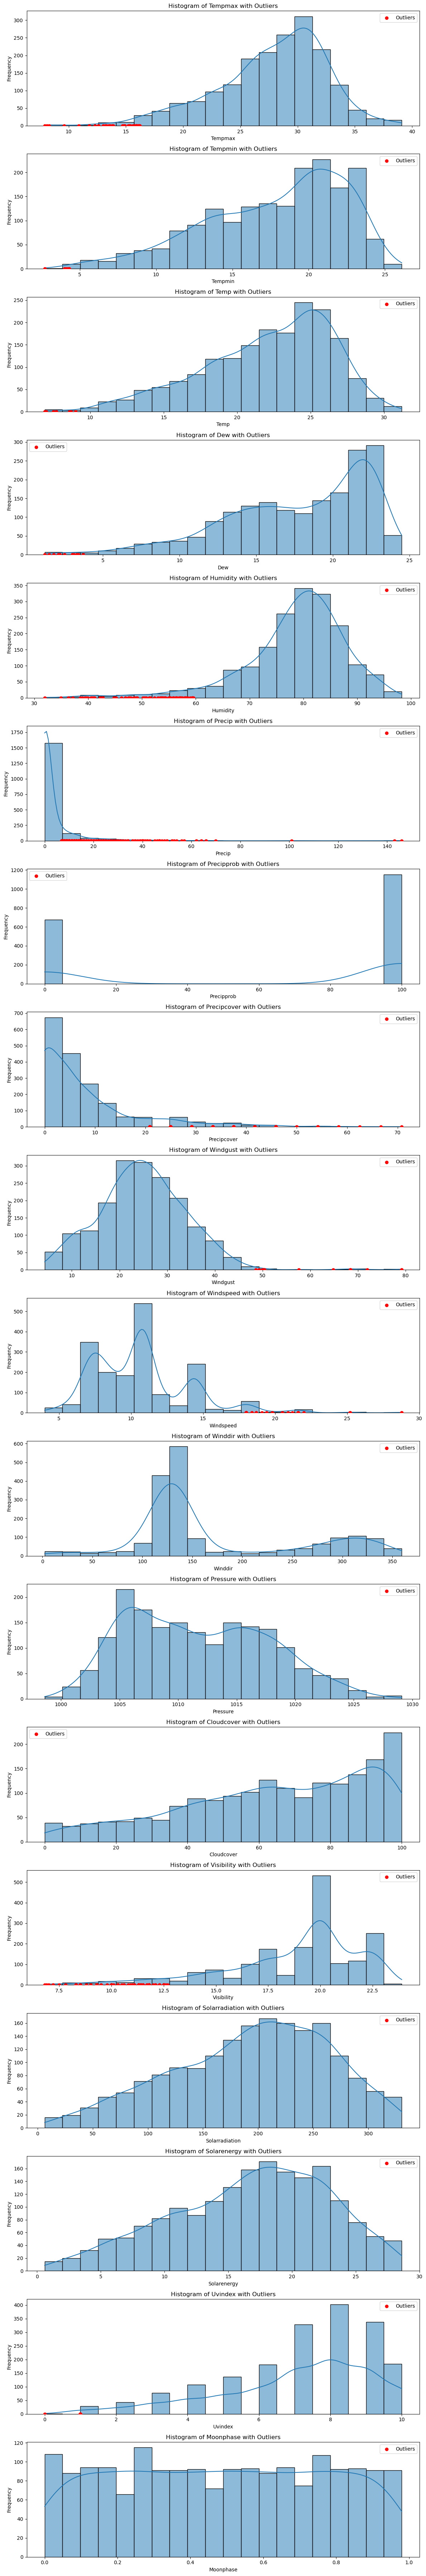

Số lượng ngoại lai trong từng cột:
Tempmax            38
Tempmin             6
Temp                8
Dew                14
Humidity           82
Precip            265
Precipprob          0
Precipcover       230
Windgust           12
Windspeed          90
Winddir             0
Pressure            0
Cloudcover          0
Visibility        118
Solarradiation      0
Solarenergy         0
Uvindex            29
Moonphase           0
dtype: int64


Location: Lạng Sơn


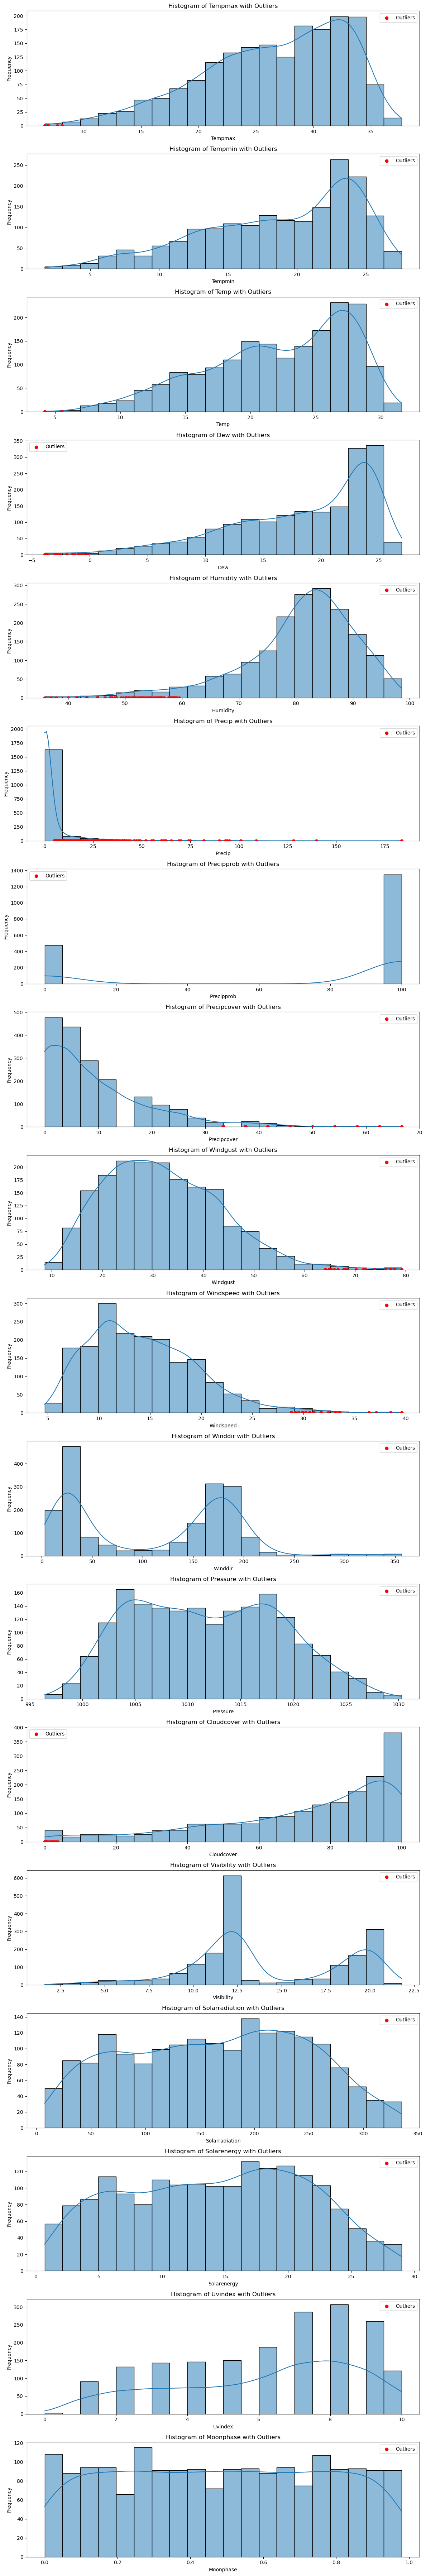

Số lượng ngoại lai trong từng cột:
Tempmax             4
Tempmin             0
Temp                2
Dew                16
Humidity           84
Precip            279
Precipprob          0
Precipcover        76
Windgust           21
Windspeed          28
Winddir             0
Pressure            0
Cloudcover         35
Visibility          0
Solarradiation      0
Solarenergy         0
Uvindex             0
Moonphase           0
dtype: int64


Location: Hà Nội


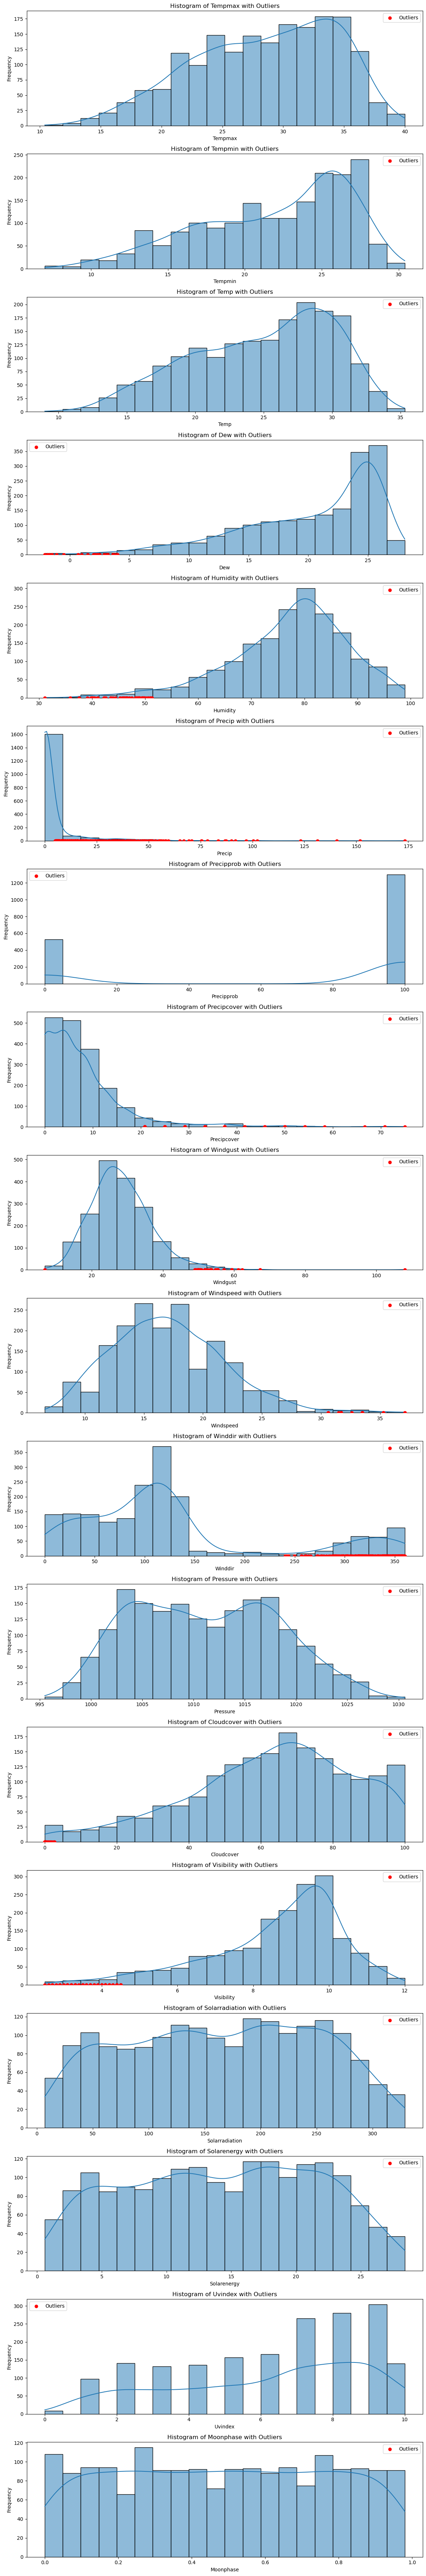

Số lượng ngoại lai trong từng cột:
Tempmax             0
Tempmin             0
Temp                0
Dew                23
Humidity           53
Precip            298
Precipprob          0
Precipcover       134
Windgust           41
Windspeed          21
Winddir           297
Pressure            0
Cloudcover         18
Visibility         61
Solarradiation      0
Solarenergy         0
Uvindex             0
Moonphase           0
dtype: int64


Location: Nghệ An


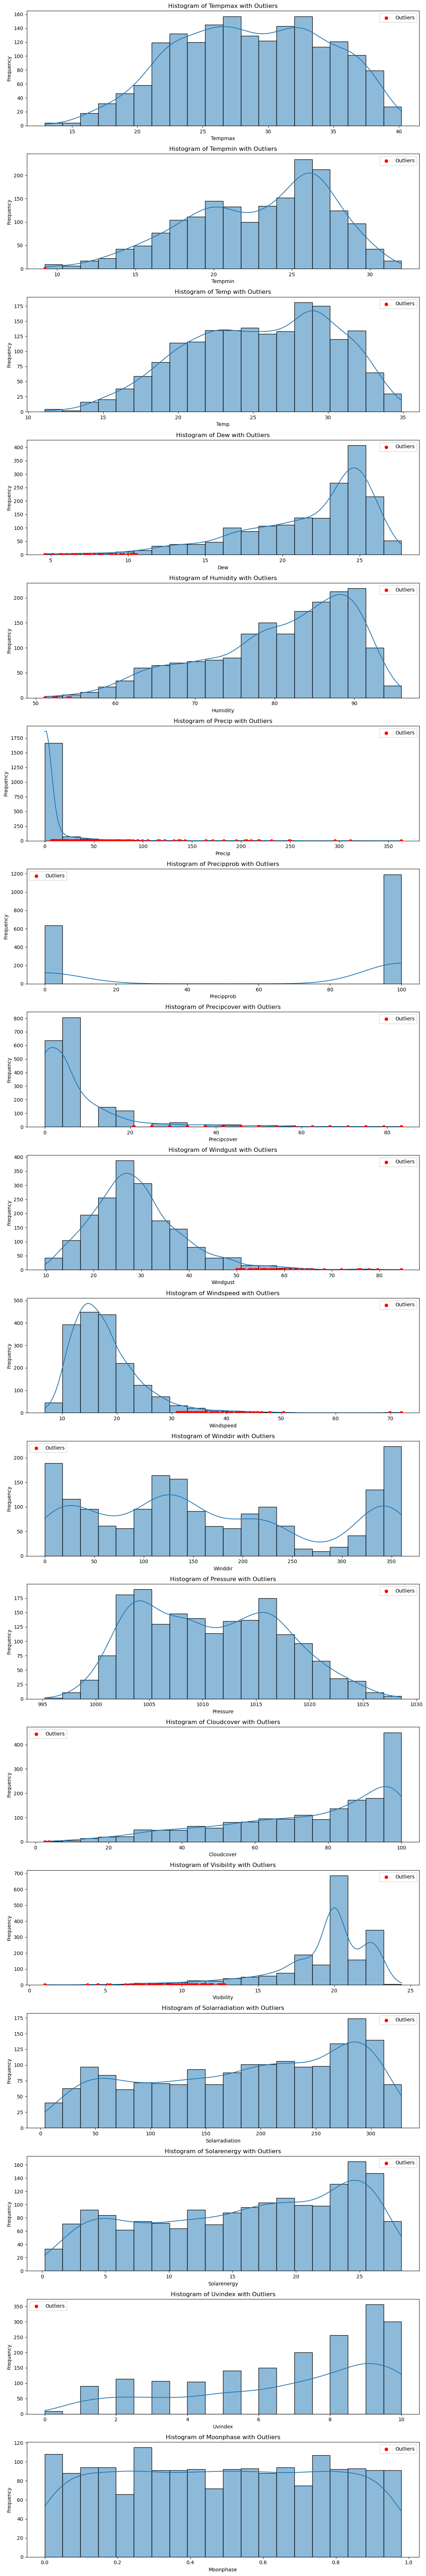

Số lượng ngoại lai trong từng cột:
Tempmax             0
Tempmin             1
Temp                0
Dew                35
Humidity            7
Precip            294
Precipprob          0
Precipcover       157
Windgust           56
Windspeed          73
Winddir             0
Pressure            0
Cloudcover          2
Visibility        102
Solarradiation      0
Solarenergy         0
Uvindex             0
Moonphase           0
dtype: int64


Location: Đà Nẵng


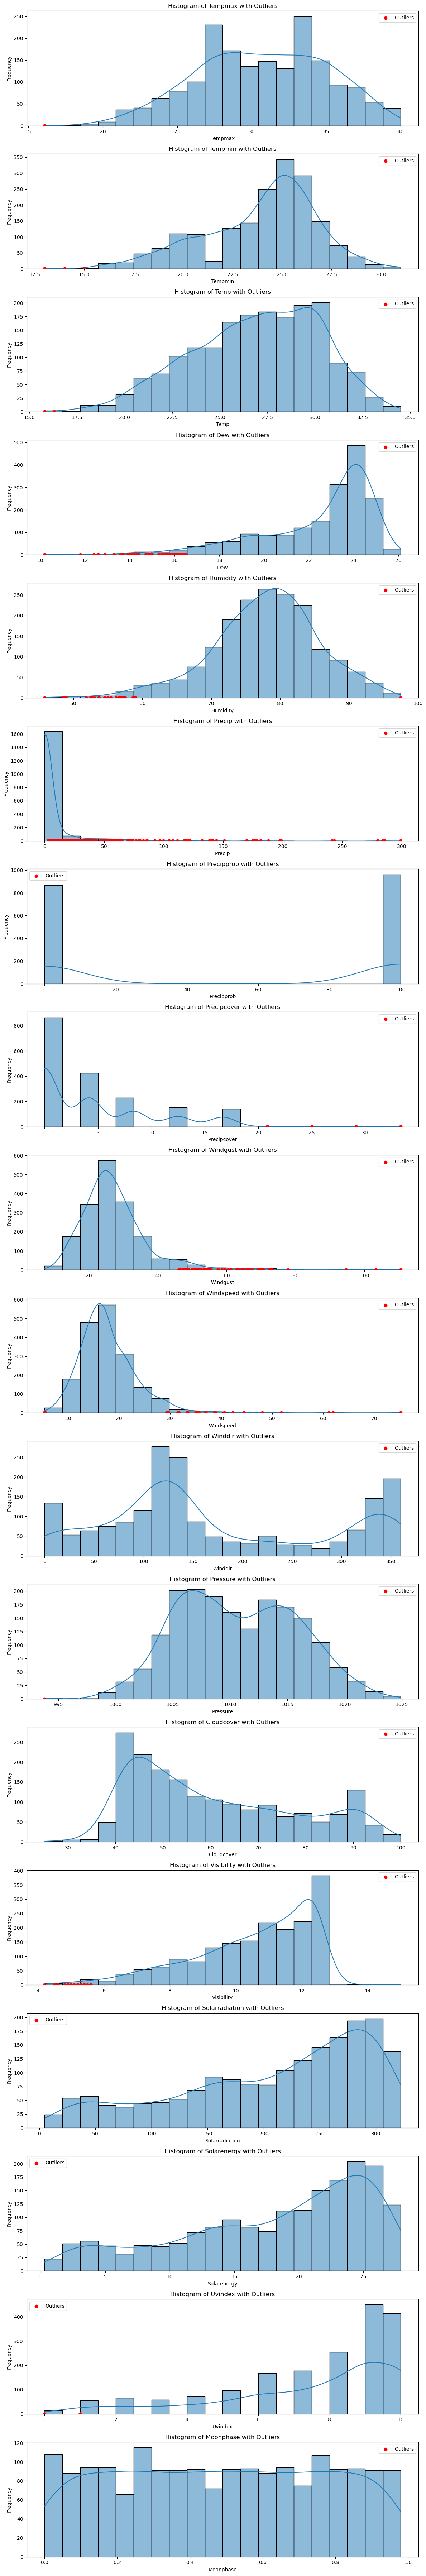

Số lượng ngoại lai trong từng cột:
Tempmax             1
Tempmin             4
Temp                2
Dew                58
Humidity           32
Precip            363
Precipprob          0
Precipcover        12
Windgust           91
Windspeed          84
Winddir             0
Pressure            1
Cloudcover          0
Visibility         23
Solarradiation      0
Solarenergy         0
Uvindex            70
Moonphase           0
dtype: int64


Location: Lâm Đồng


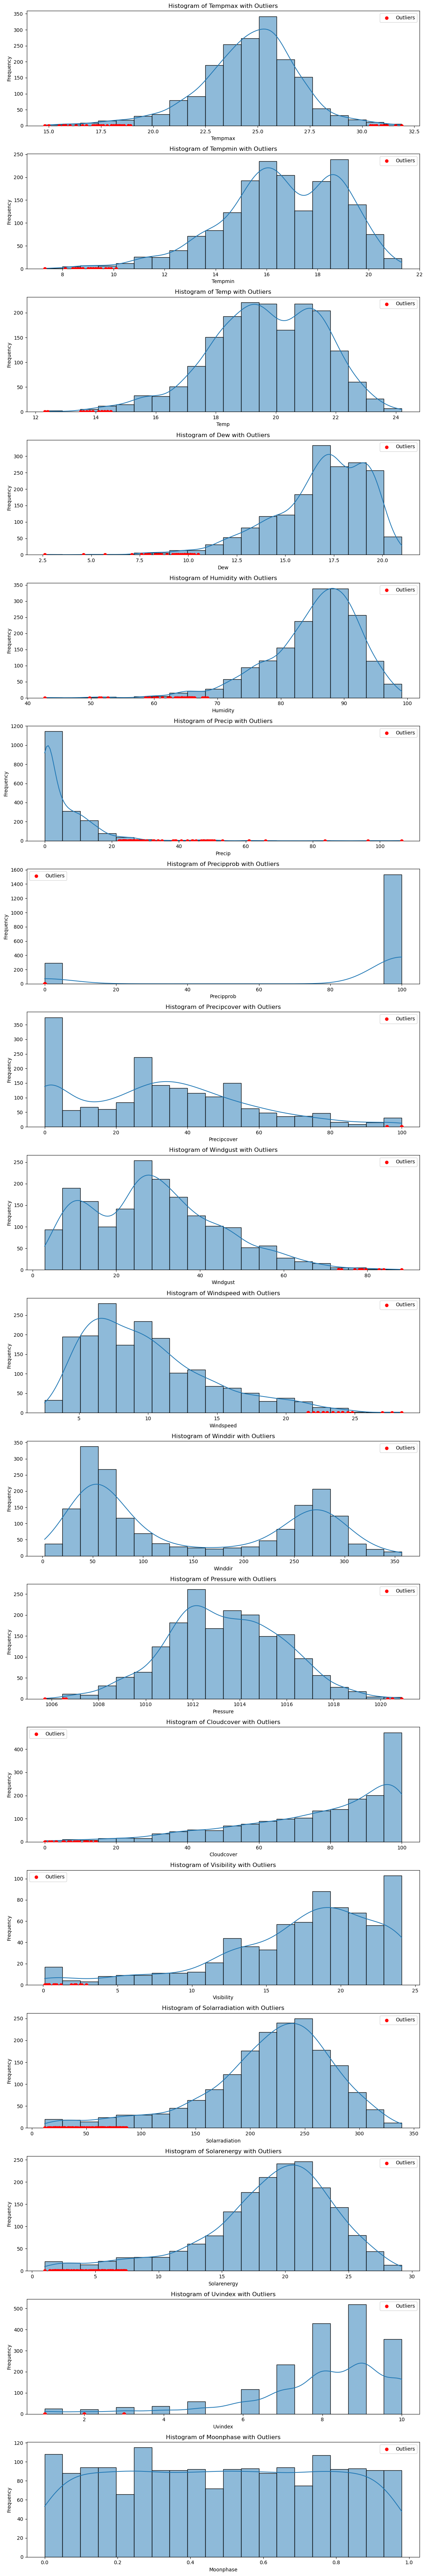

Số lượng ngoại lai trong từng cột:
Tempmax            61
Tempmin            20
Temp               19
Dew                38
Humidity           54
Precip             76
Precipprob        292
Precipcover        31
Windgust           13
Windspeed          40
Winddir             0
Pressure            7
Cloudcover         23
Visibility         24
Solarradiation     92
Solarenergy        92
Uvindex            78
Moonphase           0
dtype: int64


Location: Hồ Chí Minh


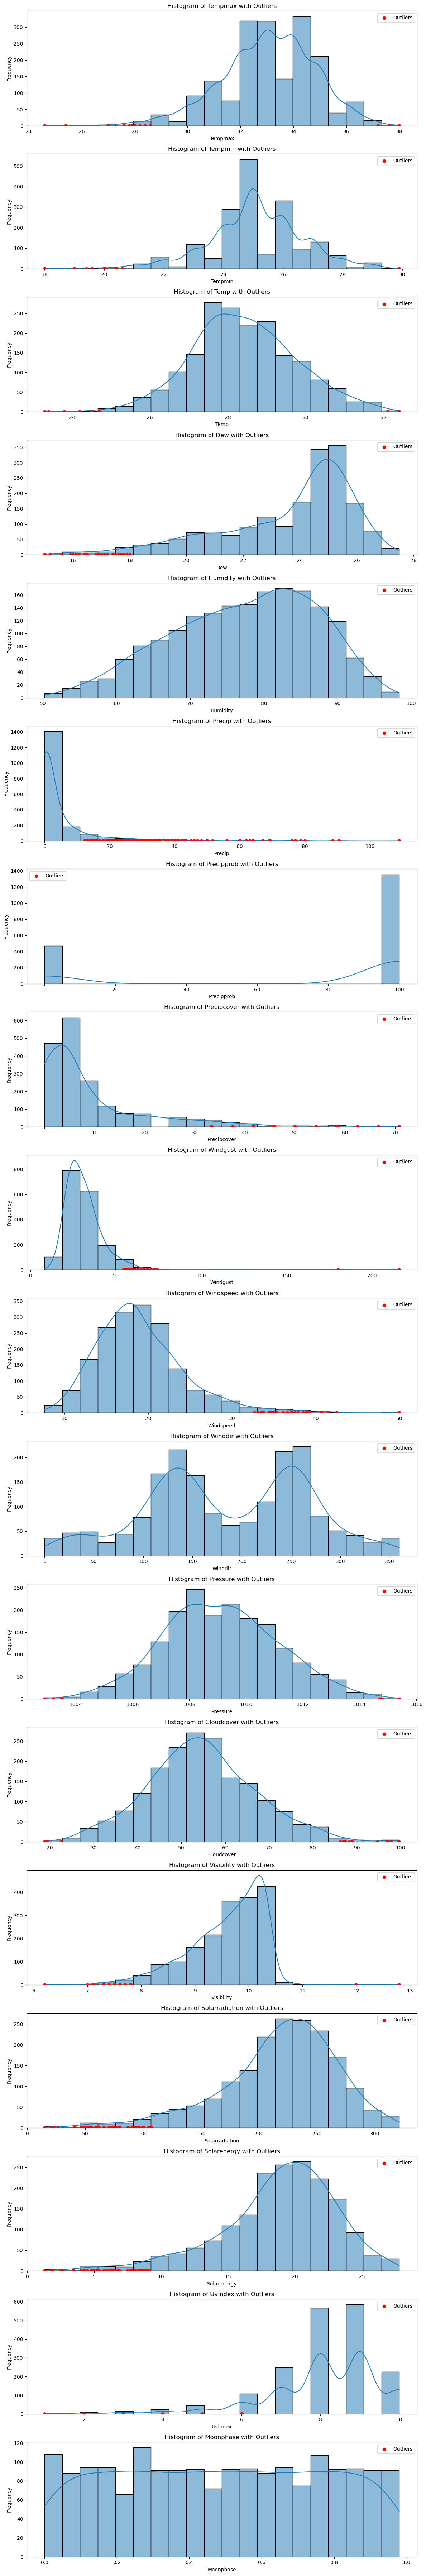

Số lượng ngoại lai trong từng cột:
Tempmax            26
Tempmin            13
Temp               10
Dew                51
Humidity            0
Precip            204
Precipprob          0
Precipcover       110
Windgust           64
Windspeed          42
Winddir             0
Pressure            7
Cloudcover         19
Visibility         40
Solarradiation     61
Solarenergy        60
Uvindex           202
Moonphase           0
dtype: int64


Location: Bến Tre


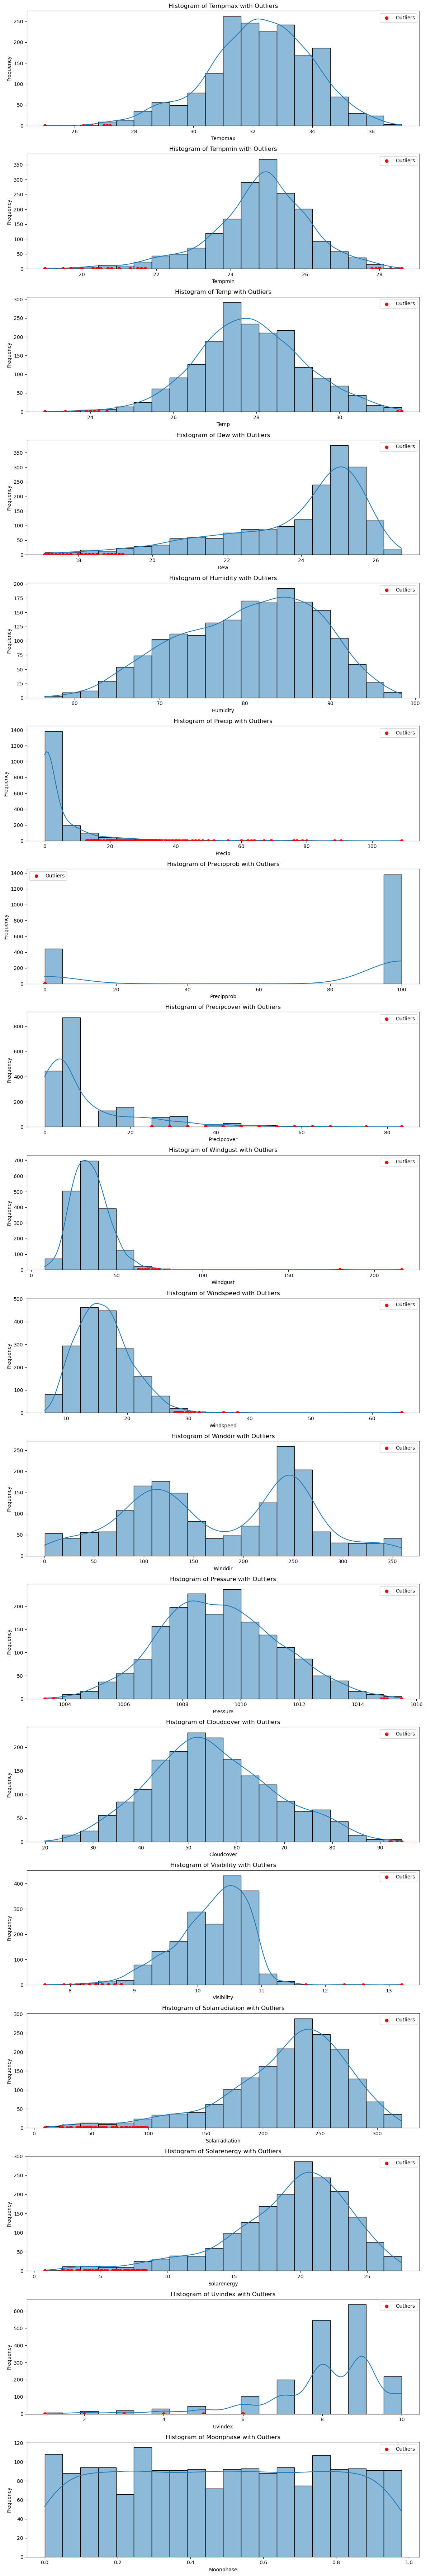

Số lượng ngoại lai trong từng cột:
Tempmax            11
Tempmin            70
Temp               14
Dew                58
Humidity            0
Precip            206
Precipprob        445
Precipcover       224
Windgust           27
Windspeed          21
Winddir             0
Pressure            8
Cloudcover          5
Visibility         40
Solarradiation     69
Solarenergy        65
Uvindex           223
Moonphase           0
dtype: int64




In [28]:
visualize_datas()